### USE EQNS FROM THE CHINESE PAPER ONLY

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import emcee

In [2]:
ncpu = mul.cpu_count()
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)

param_ranges_NULL = [(1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_lin = [(1e-20, 1e20), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_quad = [(1e-20, 1e15), (1e-20, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]


GRBs = ['GRB210619B', 'GRB210610B', 'GRB210204A', 'GRB201216C', 'GRB200829A', 'GRB200613A', 'GRB190114C', 'GRB180720B', 'GRB180703A', 'GRB171010A', 'GRB160625B', 'GRB160509A', 'GRB150821A', 'GRB150514A', 'GRB150403A', 'GRB150314A', 'GRB141028A', 'GRB140508A', 'GRB140206A', 'GRB131231A', 'GRB131108A', 'GRB130925A', 'GRB130518A', 'GRB130427A', 'GRB120119A', 'GRB100728A', 'GRB091003A', 'GRB090926A', 'GRB090618', 'GRB090328', 'GRB081221', 'GRB080916C']


grb = GRBs[0]
grbname = grb + '.txt'
grbname_wtht_ext = grbname.replace('.txt','')


arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0=67.36 #Hubble constant km -1 Mpc s -1
omega_m = 0.315
omega_l = 1 - omega_m

In [3]:
grb

'GRB210619B'

In [4]:
#MODELS

#NULL model
def nullhp(E, logEb, alpha1, alpha2, mu, zeta):
    
    eob = (E - E0) / (10**logEb)
    
    return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, logEb, alpha1, alpha2, mu, zeta):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return - (e0qg * int_z1)/H0 + nullhp(E, logEb, alpha1, alpha2, mu, zeta)

#QUADRATIC model
def quadhp(E, logEqg, logEb, alpha1, alpha2, mu, zeta):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return -1.5 * (e0qg * int_z2)/H0 + nullhp(E, logEb, alpha1, alpha2, mu, zeta)

In [5]:
#LOG-LIKELIHOODS
def loglike_null(theta):
    logEb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = nullhp(x,  logEb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_linear(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = linearhp(x, logEqg, logEb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf

def loglike_quad(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = quadhp(x, logEqg, logEb, alpha1, alpha2, mu, zeta)
        
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    return -np.inf    

In [6]:
#PRIORS
logEbmax = 1000 #keV
logEbmin = 0
alpha1min = -3
alpha1max = 10
alpha2min = -10
alpha2max = 3
mumin = 0
mumax = 3
zetamin = 0
zetamax = 4
eqglinmin = 1e-20
eqglinmax = 1e20
eqquadmin = 1e-20
eqquadmax = 1e15
logeq1min = -20
logeq1max = 20
logeq2min = -20
logeq2max = 15

In [7]:
#PRIORS

def logprior_null(theta):
    logEb, alpha1, alpha2, mu, zeta = theta
    
    if logEbmin < logEb < logEbmax and -alpha1min < alpha1 < alpha1max and alpha2min < alpha2 < alpha2max and mumin < mu < mumax and zetamin < zeta < zetamax:
        return 0
    
    return -np.inf

def logprior_linear(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if -10 < logEqg < 20 and logEbmin < logEb < logEbmax and -alpha1min < alpha1 < alpha1max and alpha2min < alpha2 < alpha2max and mumin < mu < mumax and zetamin < zeta < zetamax:
        return 0
    
    return -np.inf

def logprior_quad(theta):
    logEqg, logEb, alpha1, alpha2, mu, zeta = theta
    
    if -10 < logEqg < 15 and logEbmin < logEb < logEbmax and -alpha1min < alpha1 < alpha1max and alpha2min < alpha2 < alpha2max and mumin < mu < mumax and zetamin < zeta < zetamax:
        return 0
    
    return -np.inf

In [8]:
#POSTERIORS

def logpost_null(theta):
    logp = logprior_null(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_null(theta)

def logpost_linear(theta):
    logp = logprior_linear(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_linear(theta)

def logpost_quad(theta):
    logp = logprior_quad(theta)
    
    if not np.isfinite(logp):
        return -np.inf
    
    return logp + loglike_quad(theta)

In [9]:
#SAMPLING
nwalkers = 100
ndim_null = 5
nsteps = 5000
nburnin = 1000
init_null = np.array([np.random.uniform(Ebmin, Ebmax, nwalkers), np.random.uniform(alpha1min, alpha1max, nwalkers), np.random.uniform(alpha2min, alpha2max, nwalkers), np.random.uniform(mumin, mumax, nwalkers), np.random.uniform(zetamin, zetamax, nwalkers)]).T

sampler0 = emcee.EnsembleSampler(nwalkers, ndim_null, logpost_null, pool=mul.Pool(8), threads=8)

sampler0.run_mcmc(init_null, nsteps, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/home/darkwake/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 8/5000 [00:00<01:09, 71.86it/s]

  2%|▏         | 96/5000 [00:01<01:16, 63.90it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  2%|▏         | 103/5000 [00:01<01:17, 63.31it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  2%|▏         | 117/5000 [00:01<01:16, 64.05it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha

State([[ 1.14849501e+01  4.06242413e+00  1.57579230e-01  5.05229598e-01
   1.32702804e-01]
 [ 1.37418706e+01  3.66942588e+00  1.28218600e-01  5.45770837e-01
   1.60799052e-01]
 [ 9.38389085e+00  4.46805910e+00  1.58891919e-01  4.05217114e-01
   1.49401699e-01]
 [ 1.14524900e+01  3.72558630e+00  1.56797012e-01  4.87874026e-01
   1.59102418e-01]
 [ 1.35930815e+01  3.76284301e+00  1.32341930e-01  2.58668749e-01
   3.12681280e-01]
 [ 1.22201044e+01  4.23556872e+00  1.23879230e-01  4.50512610e-02
   5.38894528e-01]
 [ 1.05320177e+01  3.35665404e+00  1.76314889e-01  5.47377144e-01
   1.41075522e-01]
 [ 1.35101965e+01  3.27061342e+00  1.53802103e-01  8.05301559e-02
   4.46464856e-01]
 [ 1.36047353e+01  3.55445571e+00  1.32876599e-01  1.62479380e-01
   4.04664291e-01]
 [ 1.90247217e+01  3.07387714e+00  1.30199283e-01  3.55236600e-01
   3.12706748e-01]
 [ 1.31346234e+01  3.40063252e+00  1.40699494e-01  1.03939208e-01
   4.52039205e-01]
 [ 7.99693821e+00  5.71937336e+00  1.20689423e-01  4.377615

In [10]:
#LINEAR
init_lin = np.array([np.random.uniform(logeq1min, logeq1max, nwalkers), np.random.uniform(Ebmin, Ebmax, nwalkers), np.random.uniform(alpha1min, alpha1max, nwalkers), np.random.uniform(alpha2min, alpha2max, nwalkers), np.random.uniform(mumin, mumax, nwalkers), np.random.uniform(zetamin, zetamax, nwalkers)]).T
ndim_liv = 6
sampler1 = emcee.EnsembleSampler(nwalkers, ndim_liv, logpost_linear, pool=mul.Pool(8), threads=8)
sampler1.run_mcmc(init_lin, nsteps, progress=True)

  3%|▎         | 128/5000 [00:02<01:15, 64.28it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  3%|▎         | 158/5000 [00:02<01:07, 71.35it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  4%|▍         | 222/5000 [00:03<01:03, 74.69it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alph

State([[ 1.22364339e+01  9.98951874e+00  4.48161719e+00  1.41106888e-01
   7.16856955e-01  6.26827330e-02]
 [ 1.76532504e+01  5.77293476e+02 -2.19439319e+00 -8.57502677e+00
   1.90041555e+00  6.81573269e-01]
 [ 4.07872954e+00  1.21075772e+01  3.84535658e+00  1.36486850e-01
   7.56304456e-01  8.15623296e-02]
 [ 6.65482764e+00  9.00141568e+00  4.82647005e+00  1.41498106e-01
   5.03162949e-01  1.05861657e-01]
 [ 3.39709702e+00  1.26275321e+01  3.53536567e+00  1.56758490e-01
   4.86693480e-01  1.72339806e-01]
 [ 1.48427496e+01  1.47236136e+01  3.17369170e+00  1.41781341e-01
   2.21333394e-01  3.65266544e-01]
 [ 3.21770556e+00  1.08562913e+01  4.11500691e+00  1.57173471e-01
   3.95606418e-01  1.80653316e-01]
 [ 3.43966649e+00  9.53376659e+00  4.76427562e+00  1.63584104e-01
   2.94552285e-02  4.52162033e-01]
 [ 1.83858570e+01  1.04529597e+01  4.72066399e+00  1.26488345e-01
   1.79018242e-01  3.41376617e-01]
 [ 3.45471033e+00  7.77649466e+00  5.50982879e+00  1.63125526e-01
   3.13700727e-02  

In [11]:
#QUADRATIC
init_quad = np.array([np.random.uniform(logeq2min, logeq2max, nwalkers), np.random.uniform(Ebmin, Ebmax, nwalkers), np.random.uniform(alpha1min, alpha1max, nwalkers), np.random.uniform(alpha2min, alpha2max, nwalkers), np.random.uniform(mumin, mumax, nwalkers), np.random.uniform(zetamin, zetamax, nwalkers)]).T

sampler2 = emcee.EnsembleSampler(nwalkers, ndim_liv, logpost_quad, pool=mul.Pool(8), threads=8)
sampler2.run_mcmc(init_quad, nsteps, progress=True)

  0%|          | 9/5000 [00:00<00:58, 85.42it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  3%|▎         | 153/5000 [00:02<01:19, 60.70it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  3%|▎         | 160/5000 [00:02<01:20, 60.08it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**alpha1) * ((0.5 * ((1 + eob)**(1/mu))) ** ((alpha2 - alpha1) * mu))
  3%|▎         | 167/5000 [00:02<01:22, 58.46it/s]/tmp/ipykernel_41002/2456125963.py:8: RuntimeWarning: overflow encountered in power
  return zeta * (eob**

State([[9.09903510e+00 8.04366125e+00 5.58163416e+00 1.47844707e-01
  4.22091992e-02 4.42242666e-01]
 [3.59546632e+00 5.40114347e+00 5.53362821e+00 2.20915293e-01
  3.83096908e-01 8.18850947e-02]
 [3.63759608e+00 1.29853251e+01 3.10100754e+00 1.91119366e-01
  2.90577415e-01 2.62706643e-01]
 [3.72433297e+00 8.04917861e+00 5.28754509e+00 1.55329956e-01
  4.35810098e-02 4.30622098e-01]
 [3.55718414e+00 1.00319926e+01 3.66603489e+00 1.90255249e-01
  1.30288159e-01 3.30379592e-01]
 [3.58809228e+00 1.25452609e+01 3.34270723e+00 1.91301445e-01
  2.08557623e-02 4.56482301e-01]
 [3.64262422e+00 4.64789050e+00 7.01650818e+00 1.96050697e-01
  2.91979546e-02 3.26348804e-01]
 [3.63839292e+00 6.21842714e+00 6.04263314e+00 1.95447929e-01
  7.22462384e-02 2.91954518e-01]
 [3.65484629e+00 1.28715984e+01 3.18052704e+00 1.83862619e-01
  7.09212298e-02 4.14550420e-01]
 [3.65200626e+00 4.90818761e+00 7.21859105e+00 1.87774149e-01
  8.81195573e-02 2.52523344e-01]
 [3.63054703e+00 4.09229403e+00 7.58339013e+

In [12]:
#DISCARD BURN-IN
samples0 = sampler0.get_chain(discard=nburnin, flat=True)
truths0 = [np.median(samples0[:,i]) for i in range(ndim_null)]
samples1 = sampler1.get_chain(discard=nburnin, flat=True)
truths1 = [np.median(samples1[:,i]) for i in range(ndim_liv)]
samples2 = sampler2.get_chain(discard=nburnin, flat=True)
truths2 = [np.median(samples2[:,i]) for i in range(ndim_liv)]

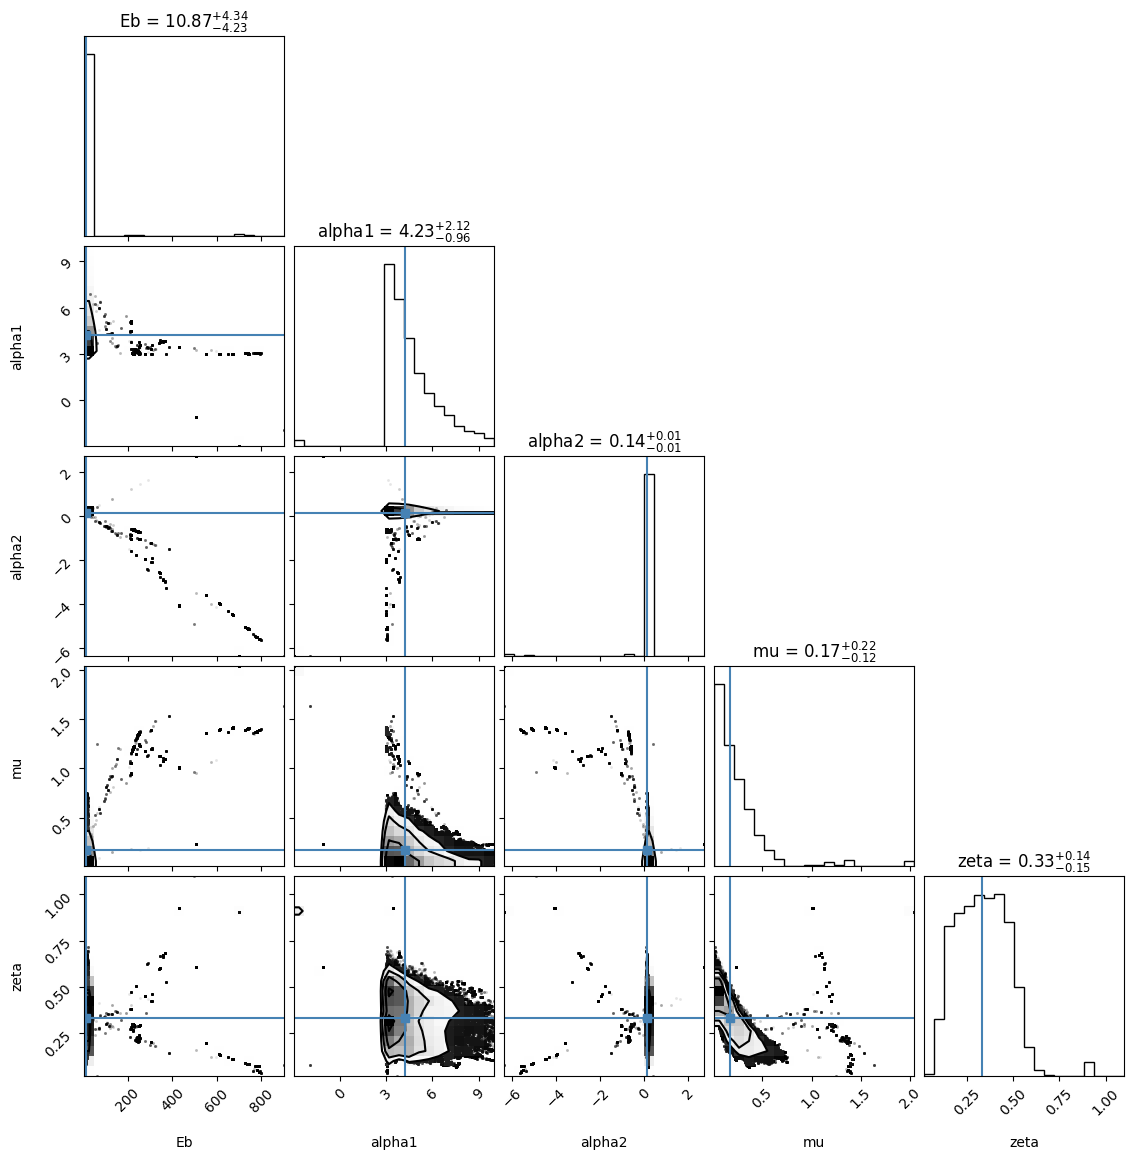

In [13]:
fig = corner(samples0, labels=['Eb', 'alpha1', 'alpha2', 'mu', 'zeta'], truths=truths0, hist_kwargs={'density' : True}, show_titles=True, title_kwargs={"fontsize": 12})

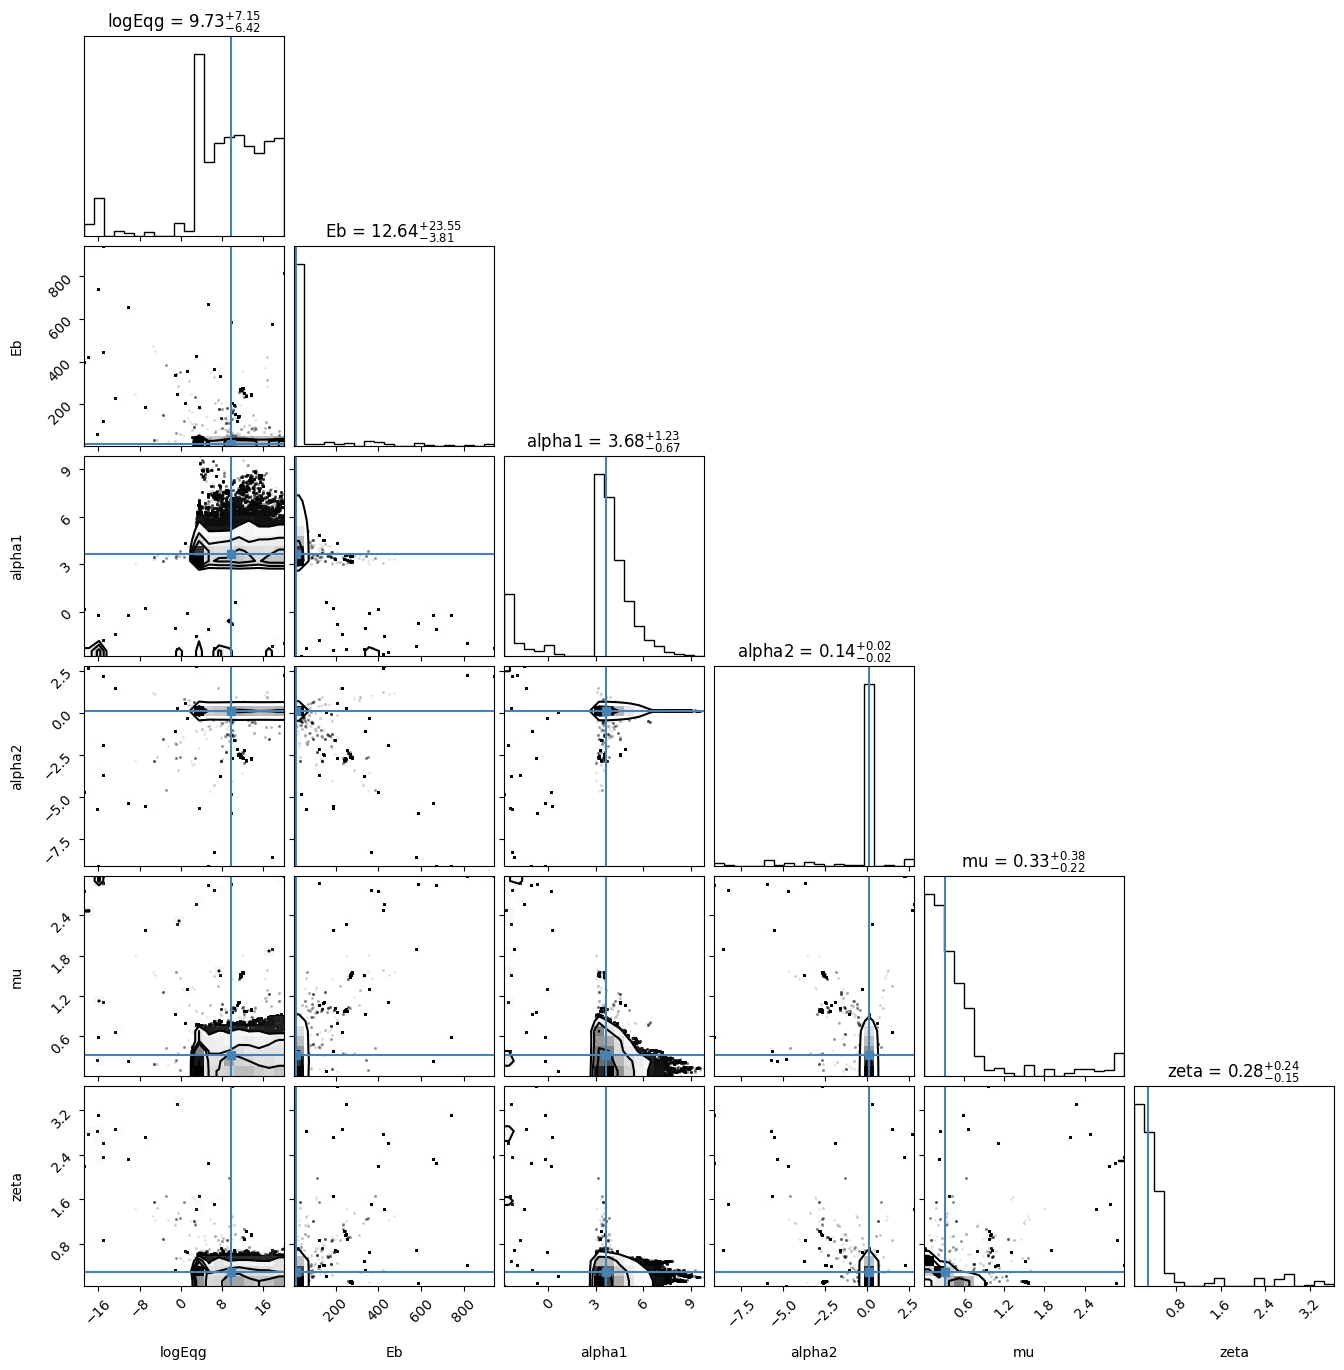

In [14]:
fig1 = corner(samples1, labels=['logEqg', 'Eb', 'alpha1', 'alpha2', 'mu', 'zeta'], truths=truths1, hist_kwargs={'density' : True}, show_titles=True, title_kwargs={"fontsize": 12})

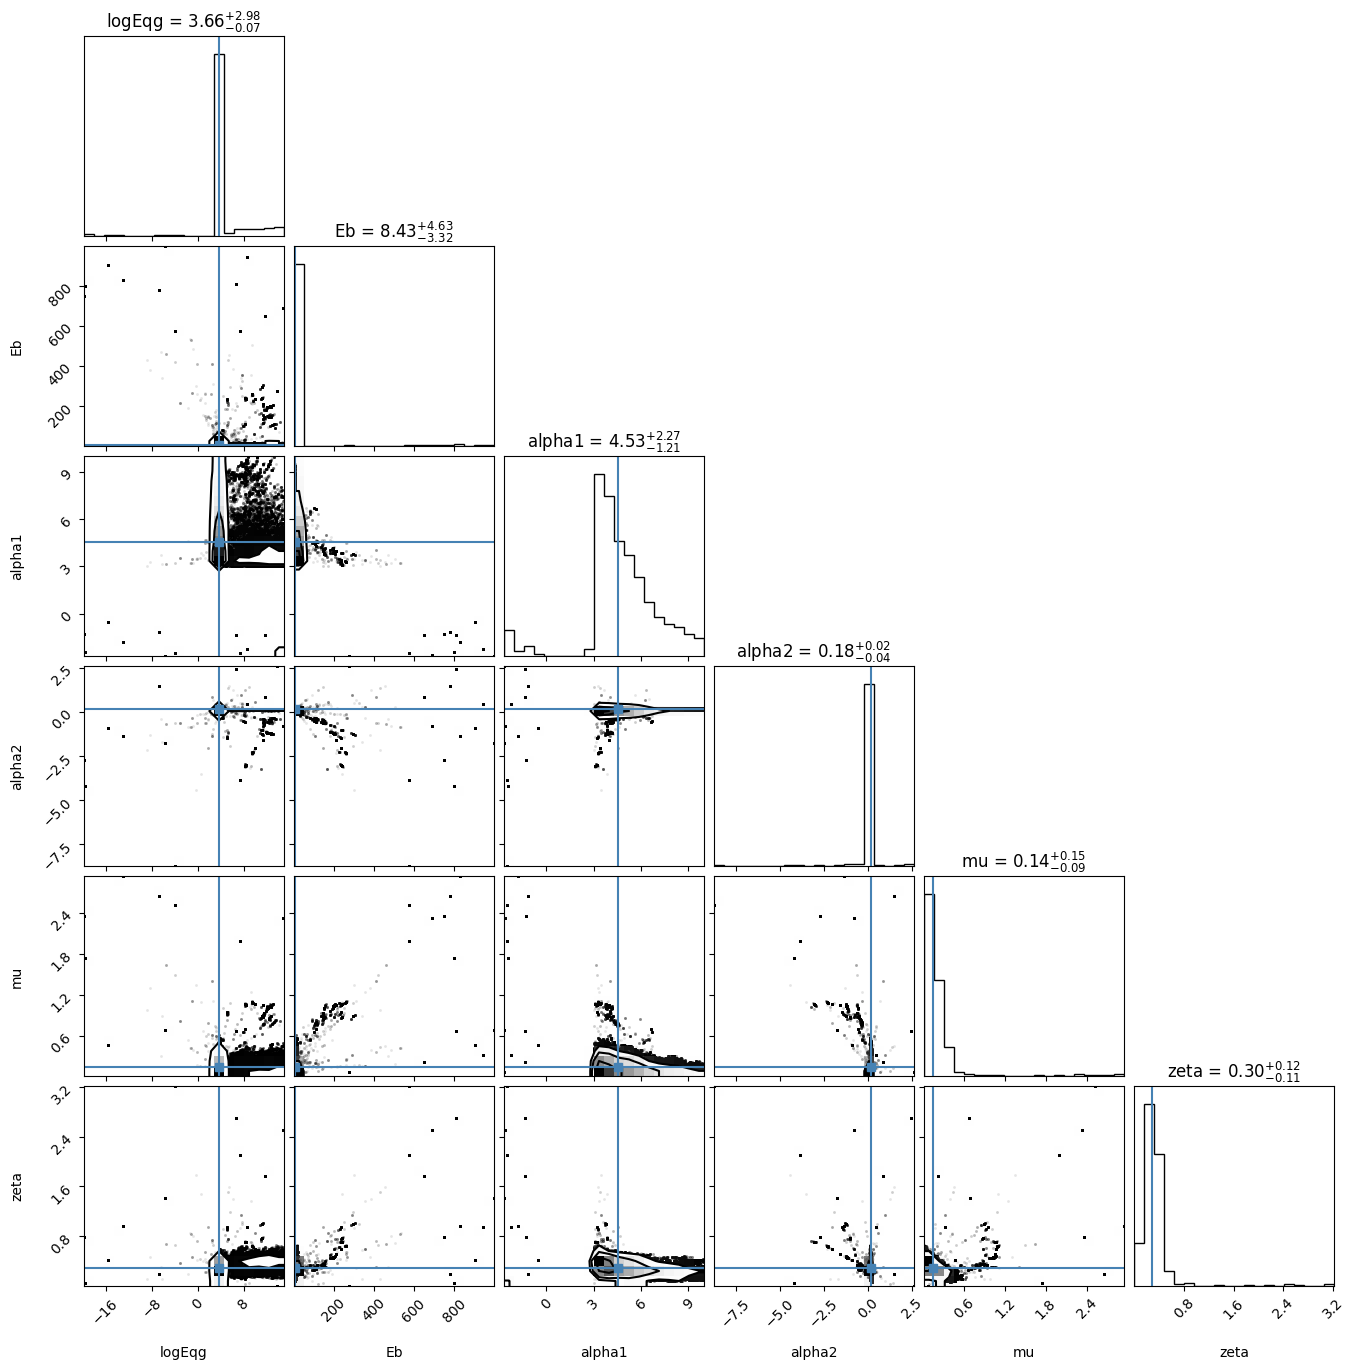

In [15]:
fig2 = corner(samples2, labels=['logEqg', 'Eb', 'alpha1', 'alpha2', 'mu', 'zeta'], truths=truths2, hist_kwargs={'density' : True}, show_titles=True, title_kwargs={"fontsize": 12})